In [1]:
import os
os.chdir("../..") #change perspective to see all dirs in repo from top

In [2]:
import sys
import json
import pickle

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import pandas as pd
import geopandas as gpd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from src.utils.dataset import split_train_val_test, get_detectron2_dataset_dicts, register_detectron2_datasets
from src.utils.dataset_mapper import TreesDatasetMapper
from src.utils.modified_retinanet import RGB_NDVI_RetinaNet

In [3]:
if os.path.exists("dsd"):
    with open("/home/h//szpdsdstion.pkl", "rb") as f:
        splits = pickle.load(f)
else:
    dir_with_images="/home/h/szprotawa_patches_256"
    samples = pd.read_pickle(os.path.join(dir_with_images, "annotation.pkl"))["patch_number"].unique()
    splits = split_train_val_test(samples, 0.7, 0.15, 0.15)
    with open(os.path.join(dir_with_images,"/home/h/szprotawa_patches_256/szprotawa_splits.pkl"), "wb") as f:
        pickle.dump(splits, f)


register_detectron2_datasets("szprotawa", dir_with_images, 
                                      splits, min_bbox_area=200, 
                                      limits={"train": -1, "val": -1, "test": -1})

In [4]:
meta = MetadataCatalog.get("szprotawa_train")
print(meta)
print(MetadataCatalog.get("szprotawa_val"))
print(MetadataCatalog.get("szprotawa_test"))

Metadata(name='szprotawa_train', thing_classes=['SickTrees'])
Metadata(name='szprotawa_val', thing_classes=['SickTrees'])
Metadata(name='szprotawa_test', thing_classes=['SickTrees'])


In [5]:
dataset_dicts = DatasetCatalog.get("szprotawa_train")
print(len(dataset_dicts))
dataset_dicts = DatasetCatalog.get("szprotawa_test")
print(len(dataset_dicts))
dataset_dicts = DatasetCatalog.get("szprotawa_val")
print(len(dataset_dicts))

1039
221
223


In [6]:
splits.keys()

dict_keys(['train', 'val', 'test'])

/home/h/szprotawa_patches_256/patch_6801.png


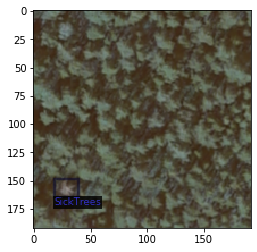

In [15]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    print(d["file_name"])
    img = cv2.imread(d["file_name"])[:, :, ::-1]
    visualizer = Visualizer(img, metadata=meta, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [16]:
# Look at training curves in tensorboard:
'''
%load_ext tensorboard
%tensorboard --logdir tboard_logs
'''

'\n%load_ext tensorboard\n%tensorboard --logdir tboard_logs\n'

In [17]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [18]:
from datetime import datetime

In [19]:
cfg = get_cfg()
cfg.MODEL.DEVICE = 'cpu' #comment it if you have GPU
cfg.OUTPUT_DIR = "tboard_logs/retinanet_test_2020-01-21T23:40/"
# cfg.OUTPUT_DIR = f"./tboard_logs/retinanet_test_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.MODEL.META_ARCHITECTURE = 'RGB_NDVI_RetinaNet' 
cfg.DATASETS.TRAIN = ("szprotawa_train",)
cfg.DATASETS.TEST = ("szprotawa_val", )
cfg.DATALOADER.NUM_WORKERS = 3

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 190_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 3000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (sick tree)

cfg.TEST.EVAL_PERIOD = 50000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 100

cfg.VIS_PERIOD = 100
cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 127.5] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0, 1.0] #ostatnia wartość wpisana z palca

Loading config /home/h/anaconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [20]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 3
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('szprotawa_val',)
  TRAIN: ('szprotawa_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 64

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class Trainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs(cfg.OUTPUT_DIR+f"/eval/{dataset_name}", exist_ok=True)

        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR+f"/eval/{dataset_name}")
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=TreesDatasetMapper(cfg, False))
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=TreesDatasetMapper(cfg, True))
    

In [22]:
if not os.path.exists(cfg.OUTPUT_DIR):
    os.makedirs(cfg.OUTPUT_DIR)

In [23]:
with open(cfg.OUTPUT_DIR + "config.yml", "w") as f:
    f.write(cfg.dump())

In [24]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/22 16:28:32 d2.engine.defaults]: Model:
RGB_NDVI_RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
   

In [ ]:
cfg.OUTPUT_DIR

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("szprotawa_val", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"].SOLVER.CHECKPOINT_PERIOD = 5000

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("szprotawa_test")

In [ ]:
import time
for d in np.random.choice(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    f, a = plt.subplots(1,3, figsize=(21,7))
    a[0].imshow(im[:,:,::-1])
    a[1].imshow(vis.get_image())
    
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_dataset_dict(d)
    a[2].imshow(vis.get_image())

In [ ]:
_ = register_detectron2_datasets("szprott", "./data/szprotawa_patches_256/", 0.7, 0.15, 0.15, 100, {'test': splits['test'][:500]})

In [ ]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("szprotawa_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "szprotawa_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

In [ ]:
outputs.keys()